In [1]:
import datetime
import numpy as np
import pandas as pd
!pip install pymarket
import pymarket as pm
import matplotlib.pyplot as plt
from pprint import pprint
import glob
%matplotlib inline
pd.set_option('display.notebook_repr_html', False)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ | done
  Created wheel for pymarket: filename=pymarket-0.7.6-py2.py3-none-any.whl size=36508 sha256=8577a90b08053d8739d80260f2a1d557c710ff418af9779f11143208604654c1
  Stored in directory: /root/.cache/pip/wheels/54/3a/c8/c3f4012c20162cac789df52b333cbfc9dbde6ef7dea6a1ef89
Successfully built pymarket


In [2]:
def uniform_price_mechanism(bids: pd.DataFrame) -> (pm.TransactionManager, dict):
    
    trans = pm.TransactionManager()
    
    buy, _ = pm.bids.demand_curve_from_bids(bids) # Creates demand curve from bids
    sell, _ = pm.bids.supply_curve_from_bids(bids) # Creates supply curve from bids

    # q_ is the quantity at which supply and demand meet
    # price is the price at which that happens
    # b_ is the index of the buyer in that position
    # s_ is the index of the seller in that position
    q_, b_, s_, price = pm.bids.intersect_stepwise(buy, sell)
    
    if b_ is None or s_ is None:
        # No market clearing can be made, return empty TransactionManager and clearing price of 0
        return trans, {'clearing quantity': 0, 'clearing price': 0} #deze moet van retail dan worden gehaald
    
    buying_bids  = bids.loc[bids['buying']].sort_values('price', ascending=False)
    selling_bids = bids.loc[~bids['buying']].sort_values('price', ascending=True)
    
    ## Filter only the trading bids.
    buying_bids = buying_bids.iloc[: b_ + 1, :]
    selling_bids = selling_bids.iloc[: s_ + 1, :]
    
    # Find the long side of the market
    buying_quantity = buying_bids.quantity.sum()
    selling_quantity = selling_bids.quantity.sum()
    
    
    if buying_quantity > selling_quantity:
        long_side = buying_bids
        short_side = selling_bids
    else:
        long_side = selling_bids
        short_side = buying_bids
        
    traded_quantity = short_side.quantity.sum()
    
    ## All the short side will trade at `price`
    ## The -1 is there because there is no clear 1 to 1 trade.
    for i, x in short_side.iterrows():
        t = (i, x.quantity, price, -1, False)
        trans.add_transaction(*t)

    ## The long side has to trade only up to the short side
    quantity_added = 0
    for i, x in long_side.iterrows():
        
        if x.quantity + quantity_added <= traded_quantity:
            x_quantity = x.quantity
        else:
            x_quantity = traded_quantity - quantity_added
        t = (i, x_quantity, price, -1, False)
        trans.add_transaction(*t)
        quantity_added += x.quantity
        
    extra = {
        'clearing quantity': q_,
        'clearing price': price
    }
    
    return trans, extra

# Observe that we add as the second argument of init the algorithm just coded
class UniformPrice(pm.Mechanism):
    """
    Interface for our new uniform price mechanism.
    
    Parameters
    -----------
    bids
        Collection of bids to run the mechanism
        with.
    """

    def __init__(self, bids, *args, **kwargs):
        """TODO: to be defined1. """
        pm.Mechanism.__init__(self, uniform_price_mechanism, bids, *args, **kwargs)

pm.market.MECHANISM['uniform'] = UniformPrice


In [3]:
from pymarket.bids import BidManager
from pymarket.mechanisms import *
from pymarket.transactions import TransactionManager
from pymarket.statistics import *
from pymarket.plot import plot_demand_curves, plot_trades_as_graph, plot_both_side_muda, plot_huang_auction
from collections import OrderedDict

MECHANISM = {
    'huang': HuangAuction,
    'p2p': P2PTrading,
    'uniform' : UniformPrice
}

STATS = {

    'percentage_traded': percentage_traded,
    'percentage_welfare': percentage_welfare,
    'profits': calculate_profits,
}


class Market():

    """General interface for calling the different
    market mechanisms

    Parameters
    ----------
    bm: BidManager
        All bids are stored in the bid manager
    transactions: TransactionManager
        The set of all tranasactions in the Market.
        This argument get updated after the market ran.
    extra: dict
        Extra information provided by the mechanisms.
        Gets updated after an execution of the run.

    Returns
    -------


    Examples
    ---------

    If everyone is buying, the transaction
    dataframe is returned empty as well as the extra
    dictionary.

    >>> mar = pm.Market()
    >>> mar.accept_bid(1, 2, 0, True)
    0
    >>> mar.accept_bid(2, 3, 1, True)
    1
    >>> trans, extra = mar.run('huang')
    >>> extra
    OrderedDict()
    >>> trans.get_df()
    Empty DataFrame
    Columns: [bid, quantity, price, source, active]
    Index: []

    If everyone is buying, the transaction
    dataframe is returned empty as well as the extra
    dictionary.

    >>> mar = pm.Market()
    >>> mar.accept_bid(1, 2, 0, False)
    0
    >>> mar.accept_bid(2, 3, 1, False)
    1
    >>> trans, extra = mar.run('huang')
    >>> extra
    OrderedDict()
    >>> trans.get_df()
    Empty DataFrame
    Columns: [bid, quantity, price, source, active]
    Index: []

    A very simple auction where nobody trades

    >>> mar = pm.Market()
    >>> mar.accept_bid(1, 3, 0, True)
    0
    >>> mar.accept_bid(1, 2, 1, False)
    1
    >>> trans, extra = mar.run('huang')
    >>> extra
    OrderedDict([('price_sell', 2.0), ('price_buy', 3.0), ('quantity_traded', 0)])
    >>> trans.get_df()
    Empty DataFrame
    Columns: [bid, quantity, price, source, active]
    Index: []

    """

    def __init__(self):
        """TODO: to be defined1."""
        self.bm = BidManager()
        self.transactions = TransactionManager()
        self.extra = OrderedDict()


    def accept_bid(self, *args):
        """Adds a bid to the bid manager

        Parameters
        ----------           
        *args :
            List of parameters requried to create a bid.
            See `BidManager` documentation.

        Returns
        -------
        bid_id: int
            The id of the new created bid in the BidManger
        
        """
        bid_id = self.bm.add_bid(*args)
        return bid_id
    
    def clear_bids(self):
        """Clears the bids list"""
        self.bids = []
        self.n_bids = 0

    def run(self, algo, *args, **kwargs):
        """Runs a given mechanism with the current
        bids

        Parameters
        ----------
        algo : str
            One of:
                * 'p2p'
                * 'huang'
                * 'muda'
            
        *args :
            Extra arguments to pass to the algorithm.

        **kwargs :
            Extra keyworded arguments to pass to the algorithm


        Returns
        -------
        transactions: TransactionManager
            The transaction manager holding all the transactions
            returned by the mechanism.
        extra: dict
            Dictionary with extra information returned by the
            executed method.

        
        """
        df = self.bm.get_df()
        mec = MECHANISM[algo](df, *args, **kwargs)
        transactions, extra = mec.run()
        self.transactions = transactions
        self.extra = extra
        return transactions, extra

    def statistics(self, reservation_prices=None, exclude=[]):
        """Computes the standard statistics of the market

        Parameters
        ----------
        reservation_prices (dict, optional) :
            the reservation prices of the users. If there is none,
            the bid will be assumed truthfull
        reservation_prices :
             (Default value = None)
        exclude :
            List of mechanisms to ignore will comuting statistics

        Returns
        -------
        stats : dict
            Dictionary with the differnt statistics. Currently:
                * percentage_welfare
                * percentage_traded
                * profits

        
        """
        stats = OrderedDict()
        extras = OrderedDict()
        if 'fees' in self.extra:
            extras['fees'] = self.extra['fees']
        extras['reservation_prices'] = reservation_prices
        for stat in STATS:
            if stat not in exclude:
                stats[stat] = STATS[stat](
                    self.bm.get_df(),
                    self.transactions.get_df(),
                    **extras
                )
        self.stats = stats
        return stats

    def plot(self):
        """Plots both demand curves"""
        df = self.bm.get_df()
        plot_demand_curves(df)

    def plot_method(self, method, ax=None):
        """
        Plots a figure specific for a given method,
        reflecting the main characteristics of its solution.
        It requires that the algorithm has run before. 


        Parameters
        ----------
        method : str
            One of `p2p`, `muda`, `huang`
        ax :
             (Default value = None)

        Returns
        -------

        
        """

        trans = self.transactions
        bids = self.bm
        e = self.extra
        if method == 'p2p':
            ax = plot_trades_as_graph(bids, trans, ax)
        elif method == 'muda':
            try:
                left_players = e['left']
                right_players = e['right']
                left_price = e['price_left']
                right_price = e['price_right']
                ax = plot_both_side_muda(
                    bids,
                    left_players,
                    right_players,
                    left_price,
                    right_price)
            except KeyError as e:
                print('Some of the parameters required were not found',
                'Make sure that the algorithm executed correctly.')
        elif method == 'huang':
            try:
                price_sell = e['price_sell']
                price_buy = e['price_buy']
                quantity_traded = e['quantity_traded']
                ax = plot_huang_auction(
                    bids,
                    price_sell,
                    price_buy,
                    quantity_traded,
                    ax
                )
            except KeyError as e:
                print('Some of the parameters required were not found',
                    'Make sure that the algorithm executed correctly.')
        return ax

In [4]:
mar = pm.Market()
r = np.random.RandomState(1234)
df = pd.read_csv('/kaggle/input/biozon-7-dagen/positions_market_ex_ante.csv') 
df['ts_delivery'] = pd.to_datetime(df['ts_delivery'], unit='s')
df.set_index('ts_delivery', inplace=True)
df['price_energy'] = df['price_energy']/1000000 #naar kWh
df = df[df['id_user'] != 777777] #exclude retailer
df


                     Unnamed: 0  id_user  qty_energy  price_energy  \
ts_delivery                                                          
2021-02-23 23:15:00           0        9         124        0.1848   
2021-02-23 23:30:00           1        9         106        0.1931   
2021-02-24 00:00:00           2        9          62        0.1698   
2021-02-24 00:45:00           3       13         102        0.1584   
2021-02-24 00:30:00           4        9          76        0.1627   
...                         ...      ...         ...           ...   
2021-03-02 15:15:00       45076        7        1200        0.4240   
2021-03-03 13:30:00       45077        7          40        0.4343   
2021-03-03 13:00:00       45078        3         120        0.2465   
2021-03-03 13:15:00       45079        3        1941        0.1352   
2021-03-03 04:45:00       45080       22        1380        0.2238   

                    quality_energy  premium_preference_quality type_position  \
ts_delive

In [5]:
df.sort_index()
start_date = "2021-02-23 23:15:00"
end_date = "2021-03-03 13:15:00"
mask = (df.index >= start_date) & (df.index < end_date)
df = df.loc[mask]
df

                     Unnamed: 0  id_user  qty_energy  price_energy  \
ts_delivery                                                          
2021-02-23 23:15:00           0        9         124        0.1848   
2021-02-23 23:30:00           1        9         106        0.1931   
2021-02-24 00:00:00           2        9          62        0.1698   
2021-02-24 00:45:00           3       13         102        0.1584   
2021-02-24 00:30:00           4        9          76        0.1627   
...                         ...      ...         ...           ...   
2021-03-02 20:00:00       45074       22          68        0.0956   
2021-03-02 15:00:00       45075        7        1040        0.1291   
2021-03-02 15:15:00       45076        7        1200        0.4240   
2021-03-03 13:00:00       45078        3         120        0.2465   
2021-03-03 04:45:00       45080       22        1380        0.2238   

                    quality_energy  premium_preference_quality type_position  \
ts_delive

# Double Auction

In [6]:
freqs = ['60min', '30min', '15min']
performance_data = []

for freq in freqs:
    groups = df.groupby(pd.Grouper(freq=freq))

    bids_all = []
    merged_dfs = []

    liquidity_data = []

    for name, group in groups:
        mar = Market()
        clearing_time = pd.to_datetime(name)
        group = group.copy()  # Create a copy of the group
        group['clearing_time'] = clearing_time

        for _, row in group.iterrows():
            bid = (row['qty_energy'], row['price_energy'], row['id_user'], row['type_position'] == 'bid', clearing_time, len(group))
            bids_all.append(bid)
            mar.accept_bid(*bid)

        bids_df = mar.bm.get_df()
        transactions, extras = mar.run('uniform')
        merged_df = pd.merge(bids_df, transactions.get_df(), left_index=True, right_on='bid', suffixes=('_bid', '_trans'))
        merged_dfs.append(merged_df)

        # Calculate liquidity metrics
        unique_offers = merged_df.loc[~merged_df['buying'], ['user', 'quantity_bid','quantity_trans']].drop_duplicates('user')
        unique_bids = merged_df.loc[merged_df['buying'], ['user', 'quantity_bid','quantity_trans']].drop_duplicates('user')
        
        bid_quantity_sum = unique_bids['quantity_bid'].sum()
        offer_quantity_sum = unique_offers['quantity_bid'].sum()
        cleared_volume = unique_bids['quantity_trans'].sum()    
        residual = cleared_volume - bid_quantity_sum
        
        local_match = cleared_volume / bid_quantity_sum * 100 if bid_quantity_sum else float('nan')
        retailer_match = 100 - local_match if bid_quantity_sum else float('nan')
    
        trading_volume = unique_bids['quantity_trans'].sum()
        order_book_depth = len(merged_df)
        price_stability = merged_df['price_trans'].std()
        average_price = merged_df['price_trans'].mean()
        
        # Step 1: Calculate market shares
        market_shares = merged_df.groupby('user')['quantity_trans'].sum() / merged_df['quantity_trans'].sum()
        # Step 2: Square the market shares
        squared_market_shares = market_shares ** 2
        # Step 3: Calculate the sum of squared market shares
        HHI = squared_market_shares.sum()
        # Step 4: Scale the HHI by multiplying by 10,000
        hhi = HHI * 10000
        
        liquidity_data.append([name, trading_volume, order_book_depth, price_stability, average_price, residual, local_match, hhi])

    merged_df = pd.concat(merged_dfs, ignore_index=False)
    merged_df.set_index('time', inplace=True)

    merged_df = merged_df[merged_df['quantity_trans'] != 0]
    
    test = merged_df

    df_bids_all = pd.DataFrame(bids_all, columns=['qty_energy', 'price_energy', 'id_user', 'is_bid', 'clearing_time', 'order_book'])
    df_bids_all.set_index('clearing_time', inplace=True)

    # Group the data by clearing time
    groups = merged_df.groupby(merged_df.index)

    liquidity_data_df = pd.DataFrame(liquidity_data, columns=['Clearing_time', 'Trading_volume', 'Order_book_depth', 'Price_stability','average_price', 'residual','local_match', 'hhi'])
    liquidity_data_df.set_index('Clearing_time', inplace=True)
    
    performance_data.append(liquidity_data_df)
df_bids_all

                     qty_energy  price_energy  id_user  is_bid  order_book
clearing_time                                                             
2021-02-23 23:15:00         124        0.1848        9    True          31
2021-02-23 23:15:00          40        0.2038        1    True          31
2021-02-23 23:15:00          40        0.1395        8    True          31
2021-02-23 23:15:00         110        0.0926        4    True          31
2021-02-23 23:15:00         211        0.1962        2    True          31
...                         ...           ...      ...     ...         ...
2021-03-03 13:00:00          70        0.3296       22    True          30
2021-03-03 13:00:00         114        0.6286        7    True          30
2021-03-03 13:00:00         140        0.2394       22   False          30
2021-03-03 13:00:00          38        0.2609        2   False          30
2021-03-03 13:00:00         120        0.2465        3   False          30

[43190 rows x 5 columns]

In [7]:
freqs = ['60min', '30min', '15min']
performance_data = []

for freq in freqs:
    groups = df.groupby(pd.Grouper(freq=freq))

    bids_all = []
    merged_dfs = []

    for name, group in groups:
        mar = Market()
        clearing_time = pd.to_datetime(name)
        group = group.copy()  # Create a copy of the group
        group['clearing_time'] = clearing_time

        for _, row in group.iterrows():
            bid = (row['qty_energy'], row['price_energy'], row['id_user'], row['type_position'] == 'bid', clearing_time, len(group))
            bids_all.append(bid)
            mar.accept_bid(*bid)

        bids_df = mar.bm.get_df()
        transactions, extras = mar.run('uniform')
        merged_df = pd.merge(bids_df, transactions.get_df(), left_index=True, right_on='bid', suffixes=('_bid', '_trans'))
        merged_dfs.append(merged_df)

    merged_df = pd.concat(merged_dfs, ignore_index=False)
    merged_df.set_index('time', inplace=True)

    merged_df = merged_df[merged_df['quantity_trans'] != 0]
    
    test = merged_df

    df_bids_all = pd.DataFrame(bids_all, columns=['qty_energy', 'price_energy', 'id_user', 'is_bid', 'clearing_time', 'order_book'])
    df_bids_all.set_index('clearing_time', inplace=True)

df_bids_all

                     qty_energy  price_energy  id_user  is_bid  order_book
clearing_time                                                             
2021-02-23 23:15:00         124        0.1848        9    True          31
2021-02-23 23:15:00          40        0.2038        1    True          31
2021-02-23 23:15:00          40        0.1395        8    True          31
2021-02-23 23:15:00         110        0.0926        4    True          31
2021-02-23 23:15:00         211        0.1962        2    True          31
...                         ...           ...      ...     ...         ...
2021-03-03 13:00:00          70        0.3296       22    True          30
2021-03-03 13:00:00         114        0.6286        7    True          30
2021-03-03 13:00:00         140        0.2394       22   False          30
2021-03-03 13:00:00          38        0.2609        2   False          30
2021-03-03 13:00:00         120        0.2465        3   False          30

[43190 rows x 5 columns]

/tmp/ipykernel_20/2280753673.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  second_df_auc = merged_df.groupby(merged_df.index).mean()  # for 15 min


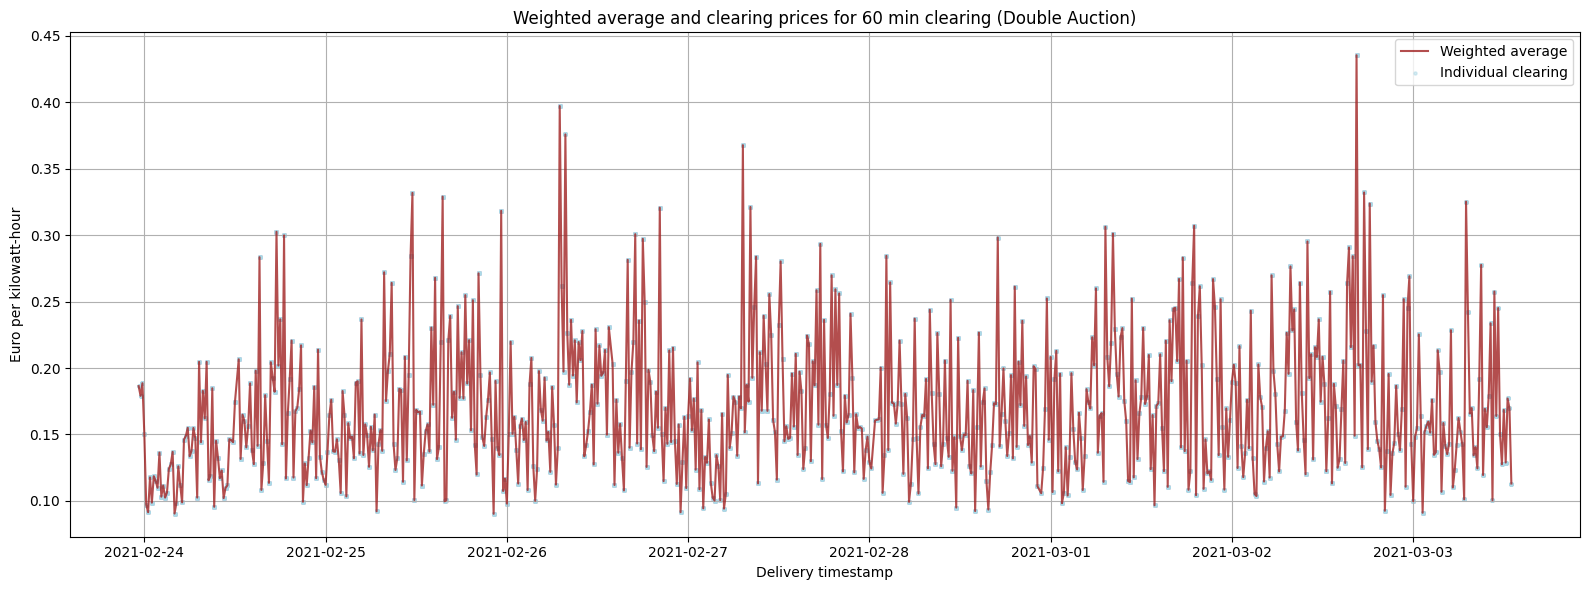

0.05265778905463162
0.17014792817679555


In [8]:
second_df_auc = merged_df.groupby(merged_df.index).mean()  # for 15 min

# Increase figure size
plt.figure(figsize=(16, 6))

# Plot weighted average
xvalues = second_df_auc.index
yvalues = second_df_auc['price_trans'].tolist()
plt.plot(xvalues, yvalues, color="#a02222", alpha=0.8, label="Weighted average")

# Plot second line
xvalues = merged_df.index
yvalues = merged_df['price_trans'].tolist()
plt.scatter(xvalues, yvalues, color="LightBlue", alpha=0.5, s=5, label="Individual clearing")

# Add labels, title, and legend
plt.xlabel("Delivery timestamp")
plt.ylabel("Euro per kilowatt-hour")
plt.title("Weighted average and clearing prices for 60 min clearing (Double Auction)")
plt.legend()

# Add grid lines
plt.grid(True)

# Display the plot
plt.tight_layout()

# Save the plot as a vector plot in EPS format
plt.savefig("auct_60min.eps", format="eps")

# Show the plot
plt.show()

volatility_auct = second_df_auc['price_trans'].std()
print(volatility_auct)
wavg_auct = second_df_auc['price_trans'].mean()
print(wavg_auct)

In [9]:
#freqs = ['15min']#, '30min', '15min']

performance_data = []
liquidity_data = []

for freq in freqs:
    for name, group in df.groupby(pd.Grouper(freq=freq)):
        mar = Market()
        clearing_time = pd.to_datetime(name)
        group = group.copy()
        group['clearing_time'] = clearing_time

        for _, row in group.iterrows():
            bid = (row['qty_energy'], row['price_energy'], row['id_user'], row['type_position'] == 'bid', clearing_time, row['quality_energy'])
            mar.accept_bid(*bid)

        bids_df = mar.bm.get_df()
        transactions, extras = mar.run('uniform')
        merged_df = pd.merge(bids_df, transactions.get_df(), left_index=True, right_on='bid', suffixes=('_bid', '_trans'))

        unique_offers = merged_df.loc[~merged_df['buying'], ['user', 'quantity_bid', 'quantity_trans']].drop_duplicates('user')
        unique_bids = merged_df.loc[merged_df['buying'], ['user', 'quantity_bid', 'quantity_trans']].drop_duplicates('user')

        trading_volume = unique_bids['quantity_trans'].sum()
        order_book_depth = len(merged_df)
        average_price = merged_df['price_trans'].mean()
        residual = trading_volume - unique_bids['quantity_bid'].sum()
        unique_participants = len(merged_df['user'].unique())
        
        # Step 1: Calculate market shares
        market_shares = merged_df.groupby('user')['quantity_trans'].sum() / merged_df['quantity_trans'].sum()
        # Step 2: Square the market shares
        squared_market_shares = market_shares ** 2
        # Step 3: Calculate the sum of squared market shares
        HHI = squared_market_shares.sum()
        # Step 4: Scale the HHI by multiplying by 10,000
        hhi = HHI * 10000
        
        liquidity_data.append([clearing_time, trading_volume, order_book_depth, average_price, residual, hhi, unique_participants])

liquidity_data_df = pd.DataFrame(liquidity_data, columns=['Clearing_time', 'Trading Volume (kWh)', 'Order Book Depth', 'Average Price (€/kWh)', 'Imported Volume (kWh)', 'hhi','unique_participants'])
performance_data.append(liquidity_data_df)

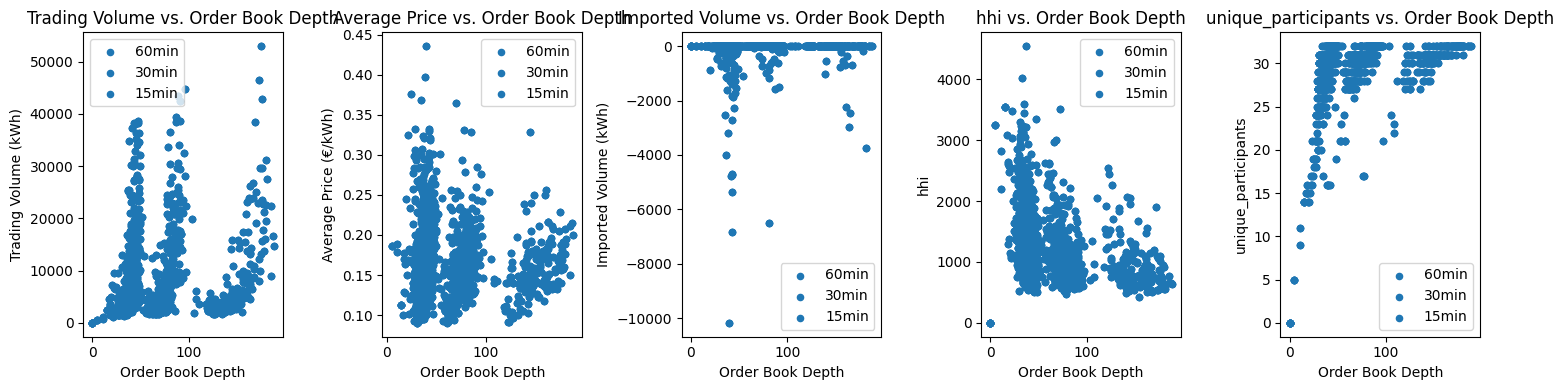

In [10]:
fig, axs = plt.subplots(1, 5, figsize=(15, 4))

for freq in freqs:
    performance_data[0].plot.scatter(x='Order Book Depth', y='Trading Volume (kWh)', ax=axs[0], label=freq)
    performance_data[0].plot.scatter(x='Order Book Depth', y='Average Price (€/kWh)', ax=axs[1], label=freq)
    performance_data[0].plot.scatter(x='Order Book Depth', y='Imported Volume (kWh)', ax=axs[2], label=freq)
    performance_data[0].plot.scatter(x='Order Book Depth', y='hhi', ax=axs[3], label=freq)
    performance_data[0].plot.scatter(x='Order Book Depth', y='unique_participants', ax=axs[4], label=freq)
        
axs[0].set_title('Trading Volume vs. Order Book Depth')
axs[1].set_title('Average Price vs. Order Book Depth')
axs[2].set_title('Imported Volume vs. Order Book Depth')
axs[3].set_title('hhi vs. Order Book Depth')
axs[4].set_title('unique_participants vs. Order Book Depth')

axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()
axs[4].legend()

plt.tight_layout()
plt.show()

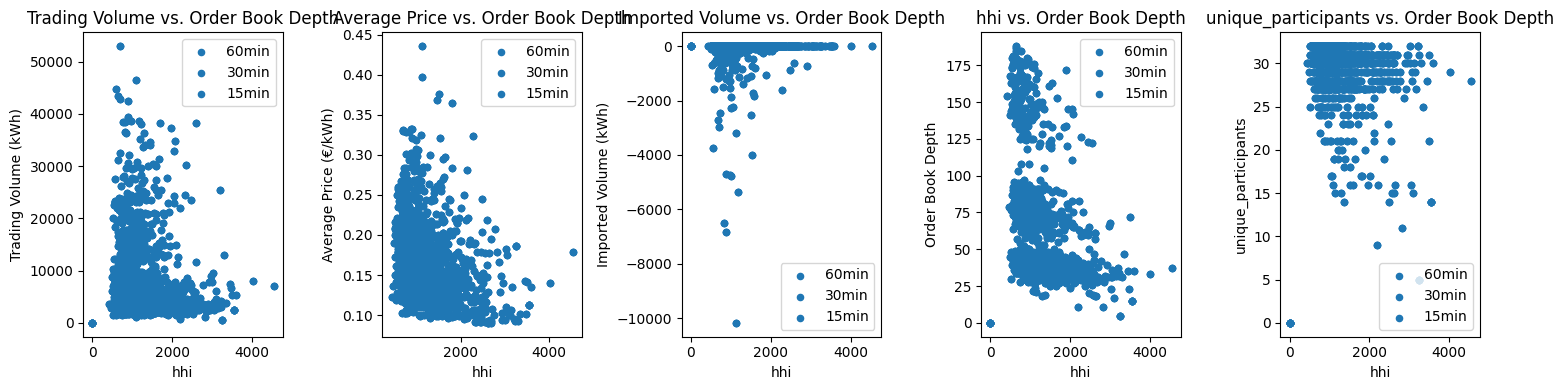

In [11]:
fig, axs = plt.subplots(1, 5, figsize=(15, 4))

for freq in freqs:
    performance_data[0].plot.scatter(x='hhi', y='Trading Volume (kWh)', ax=axs[0], label=freq)
    performance_data[0].plot.scatter(x='hhi', y='Average Price (€/kWh)', ax=axs[1], label=freq)
    performance_data[0].plot.scatter(x='hhi', y='Imported Volume (kWh)', ax=axs[2], label=freq)
    performance_data[0].plot.scatter(x='hhi', y='Order Book Depth', ax=axs[3], label=freq)
    performance_data[0].plot.scatter(x='hhi', y='unique_participants', ax=axs[4], label=freq)
        
axs[0].set_title('Trading Volume vs. Order Book Depth')
axs[1].set_title('Average Price vs. Order Book Depth')
axs[2].set_title('Imported Volume vs. Order Book Depth')
axs[3].set_title('hhi vs. Order Book Depth')
axs[4].set_title('unique_participants vs. Order Book Depth')

axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()
axs[4].legend()

plt.tight_layout()
plt.show()


In [12]:
import pandas as pd

csv_data = []

for entry in liquidity_data:
    clearing_time, trading_volume, order_book_depth, average_price, imported_volume, hhi, unique_participants = entry
    
    csv_data.extend([
        ['Trading Volume (kWh)', trading_volume, order_book_depth, clearing_time],
        ['Average Price (€/kWh)', average_price, order_book_depth, clearing_time],
        ['Imported Volume (kWh)', imported_volume, order_book_depth, clearing_time],
        ['hhi', hhi, order_book_depth, clearing_time],
        ['unique_participants', unique_participants, order_book_depth, clearing_time]
    ])

csv_data_df = pd.DataFrame(csv_data, columns=['Criteria', 'Score', 'Order Book Depth', 'Frequency'])
csv_data_df.to_csv('performance_data_auct.csv', index=False)
csv_data_df

                   Criteria        Score  Order Book Depth           Frequency
0      Trading Volume (kWh)  2823.000000                35 2021-02-23 23:00:00
1     Average Price (€/kWh)     0.179100                35 2021-02-23 23:00:00
2     Imported Volume (kWh)     0.000000                35 2021-02-23 23:00:00
3                       hhi  2458.572783                35 2021-02-23 23:00:00
4       unique_participants    23.000000                35 2021-02-23 23:00:00
...                     ...          ...               ...                 ...
6375   Trading Volume (kWh)  2388.000000                15 2021-03-03 13:00:00
6376  Average Price (€/kWh)     0.113100                15 2021-03-03 13:00:00
6377  Imported Volume (kWh)     0.000000                15 2021-03-03 13:00:00
6378                    hhi  3538.837228                15 2021-03-03 13:00:00
6379    unique_participants    14.000000                15 2021-03-03 13:00:00

[6380 rows x 4 columns]

In [13]:
import pandas as pd

csv_data = []

for entry in liquidity_data:
    clearing_time, trading_volume, order_book_depth, average_price, imported_volume, hhi, unique_participants = entry
    
    csv_data.extend([
        [order_book_depth, hhi, freq]
    ])

csv_data_df = pd.DataFrame(csv_data, columns=['HHI','Order Book Depth', 'Frequency'])
csv_data_df.to_csv('performance_data_auct.csv', index=False)
csv_data_df

      HHI  Order Book Depth Frequency
0      35       2458.572783     15min
1     122       2539.182705     15min
2     133       1538.132869     15min
3     143        774.662883     15min
4     154        431.066052     15min
...   ...               ...       ...
1271   22       1071.012365     15min
1272   18       2613.488992     15min
1273   18       2646.570632     15min
1274   18       1296.817756     15min
1275   15       3538.837228     15min

[1276 rows x 3 columns]

In [14]:
merged_df
snapshot_auc = merged_df.loc[merged_df.index == '2021-02-24 09:15:00']
snapshot_auc.to_csv('snapshot_auc.csv', index=True)

In [15]:
market_shares = merged_df.groupby('user')['quantity_trans'].sum() / merged_df['quantity_trans'].sum()
print(market_shares)
# Step 2: Square the market shares
squared_market_shares = market_shares ** 2
# Step 3: Calculate the sum of squared market shares
HHI = squared_market_shares.sum()
# Step 4: Scale the HHI by multiplying by 10,000
hhi = HHI * 10000
print(hhi)

user
1     0.550461
2     0.003978
3     0.024707
5     0.004816
7     0.023869
10    0.024079
12    0.020101
14    0.020310
17    0.032245
18    0.010050
22    0.014657
26    0.010050
28    0.050251
31    0.210427
Name: quantity_trans, dtype: float64
3538.8372277355516


# Negotiation-based mechanism (P2P)

In [16]:
freqs = ['60min', '30min', '15min']
performance_data = []

for freq in freqs:
    groups = df.groupby(pd.Grouper(freq=freq))

    bids_all = []
    merged_dfs = []

    for name, group in groups:
        mar = Market()
        clearing_time = pd.to_datetime(name)
        group = group.copy()  # Create a copy of the group
        group['clearing_time'] = clearing_time

        for _, row in group.iterrows():
            bid = (row['qty_energy'], row['price_energy'], row['id_user'], row['type_position'] == 'bid', clearing_time, len(group))
            bids_all.append(bid)
            mar.accept_bid(*bid)

        bids_df = mar.bm.get_df()
        transactions, extras = mar.run('p2p',r=r)
        merged_df = pd.merge(bids_df, transactions.get_df(), left_index=True, right_on='bid', suffixes=('_bid', '_trans'))
        merged_dfs.append(merged_df)

    merged_df = pd.concat(merged_dfs, ignore_index=False)
    merged_df.set_index('time', inplace=True)

    merged_df = merged_df[merged_df['quantity_trans'] != 0]
    
    test = merged_df

    df_bids_all = pd.DataFrame(bids_all, columns=['qty_energy', 'price_energy', 'id_user', 'is_bid', 'clearing_time', 'order_book'])
    df_bids_all.set_index('clearing_time', inplace=True)

df_bids_all

                     qty_energy  price_energy  id_user  is_bid  order_book
clearing_time                                                             
2021-02-23 23:15:00         124        0.1848        9    True          31
2021-02-23 23:15:00          40        0.2038        1    True          31
2021-02-23 23:15:00          40        0.1395        8    True          31
2021-02-23 23:15:00         110        0.0926        4    True          31
2021-02-23 23:15:00         211        0.1962        2    True          31
...                         ...           ...      ...     ...         ...
2021-03-03 13:00:00          70        0.3296       22    True          30
2021-03-03 13:00:00         114        0.6286        7    True          30
2021-03-03 13:00:00         140        0.2394       22   False          30
2021-03-03 13:00:00          38        0.2609        2   False          30
2021-03-03 13:00:00         120        0.2465        3   False          30

[43190 rows x 5 columns]

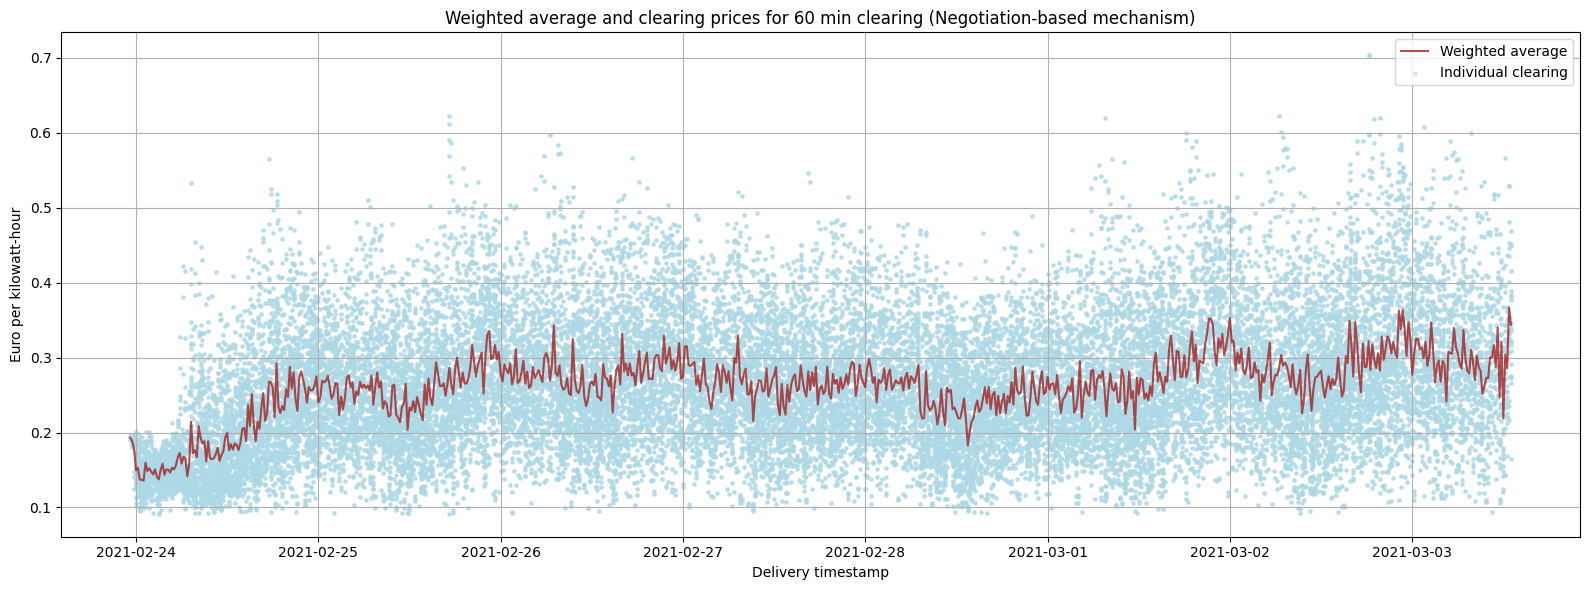

0.04101947665723975
0.2626674949283257


In [17]:
import matplotlib.pyplot as plt

second_df_p2p = merged_df.groupby(merged_df.index).mean()  # for 15 min

# Increase figure size
plt.figure(figsize=(16, 6))

# Plot weighted average
xvalues = second_df_p2p.index
yvalues = second_df_p2p['price_trans'].tolist()
plt.plot(xvalues, yvalues, color="#a02222", alpha=0.8, label="Weighted average")

# Plot second line
xvalues = merged_df.index
yvalues = merged_df['price_trans'].tolist()
plt.scatter(xvalues, yvalues, color="LightBlue", alpha=0.5, s=5, label="Individual clearing")

# Add labels, title, and legend
plt.xlabel("Delivery timestamp")
plt.ylabel("Euro per kilowatt-hour")
plt.title("Weighted average and clearing prices for 60 min clearing (Negotiation-based mechanism)")
plt.legend()

# Add grid lines
plt.grid(True)

# Display the plot
plt.tight_layout()

# Save the plot as a vector plot in EPS format
plt.savefig("p2p_60min.eps", format="eps")

# Show the plot
plt.show()

volatility_p2p = second_df_p2p['price_trans'].std()
print(volatility_p2p)
wavg_p2p = second_df_p2p['price_trans'].mean()
print(wavg_p2p)

In [18]:
performance_data = []
liquidity_data = []

for freq in freqs:
    for name, group in df.groupby(pd.Grouper(freq=freq)):
        mar = Market()
        clearing_time = pd.to_datetime(name)
        group = group.copy()
        group['clearing_time'] = clearing_time

        for _, row in group.iterrows():
            bid = (row['qty_energy'], row['price_energy'], row['id_user'], row['type_position'] == 'bid', clearing_time, row['quality_energy'])
            mar.accept_bid(*bid)

        bids_df = mar.bm.get_df()
        transactions, extras = mar.run('p2p',r=r)
        merged_df = pd.merge(bids_df, transactions.get_df(), left_index=True, right_on='bid', suffixes=('_bid', '_trans'))

        unique_offers = merged_df.loc[~merged_df['buying'], ['user', 'quantity_bid', 'quantity_trans']].drop_duplicates('user')
        unique_bids = merged_df.loc[merged_df['buying'], ['user', 'quantity_bid', 'quantity_trans']].drop_duplicates('user')

        trading_volume = unique_bids['quantity_trans'].sum()
        order_book_depth = len(merged_df)
        average_price = merged_df['price_trans'].mean()
        residual = trading_volume - unique_bids['quantity_bid'].sum()
        unique_participants = len(merged_df['user'].unique())
        
        # Step 1: Calculate market shares
        market_shares = merged_df.groupby('user')['quantity_trans'].sum() / merged_df['quantity_trans'].sum()
        # Step 2: Square the market shares
        squared_market_shares = market_shares ** 2
        # Step 3: Calculate the sum of squared market shares
        HHI = squared_market_shares.sum()
        # Step 4: Scale the HHI by multiplying by 10,000
        hhi = HHI * 10000
        
        liquidity_data.append([clearing_time, trading_volume, order_book_depth, average_price, residual, hhi, unique_participants])

liquidity_data_df = pd.DataFrame(liquidity_data, columns=['Clearing_time', 'Trading Volume (kWh)', 'Order Book Depth', 'Average Price (€/kWh)', 'Imported Volume (kWh)', 'hhi','unique_participants'])
performance_data.append(liquidity_data_df)

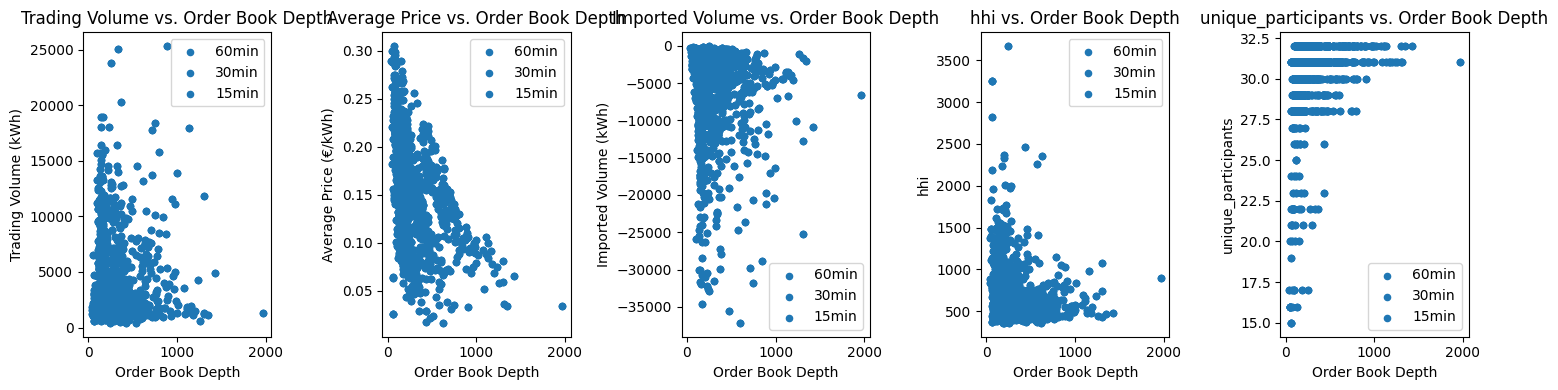

In [19]:
fig, axs = plt.subplots(1, 5, figsize=(15, 4))

for freq in freqs:
    performance_data[0].plot.scatter(x='Order Book Depth', y='Trading Volume (kWh)', ax=axs[0], label=freq)
    performance_data[0].plot.scatter(x='Order Book Depth', y='Average Price (€/kWh)', ax=axs[1], label=freq)
    performance_data[0].plot.scatter(x='Order Book Depth', y='Imported Volume (kWh)', ax=axs[2], label=freq)
    performance_data[0].plot.scatter(x='Order Book Depth', y='hhi', ax=axs[3], label=freq)
    performance_data[0].plot.scatter(x='Order Book Depth', y='unique_participants', ax=axs[4], label=freq)
        
axs[0].set_title('Trading Volume vs. Order Book Depth')
axs[1].set_title('Average Price vs. Order Book Depth')
axs[2].set_title('Imported Volume vs. Order Book Depth')
axs[3].set_title('hhi vs. Order Book Depth')
axs[4].set_title('unique_participants vs. Order Book Depth')

axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()
axs[4].legend()

plt.tight_layout()
plt.show()

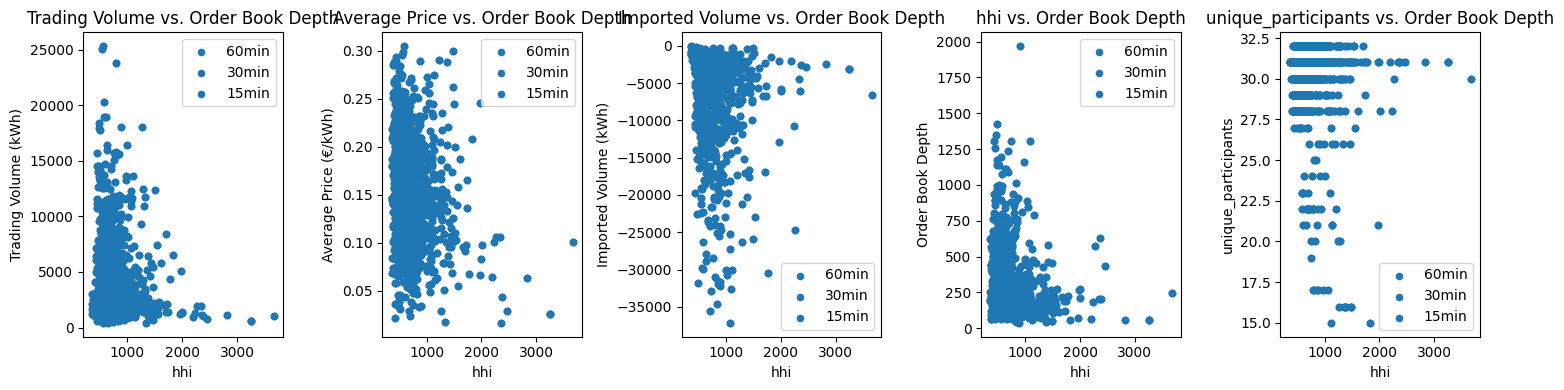

In [20]:
fig, axs = plt.subplots(1, 5, figsize=(15, 4))

for freq in freqs:
    performance_data[0].plot.scatter(x='hhi', y='Trading Volume (kWh)', ax=axs[0], label=freq)
    performance_data[0].plot.scatter(x='hhi', y='Average Price (€/kWh)', ax=axs[1], label=freq)
    performance_data[0].plot.scatter(x='hhi', y='Imported Volume (kWh)', ax=axs[2], label=freq)
    performance_data[0].plot.scatter(x='hhi', y='Order Book Depth', ax=axs[3], label=freq)
    performance_data[0].plot.scatter(x='hhi', y='unique_participants', ax=axs[4], label=freq)
        
axs[0].set_title('Trading Volume vs. Order Book Depth')
axs[1].set_title('Average Price vs. Order Book Depth')
axs[2].set_title('Imported Volume vs. Order Book Depth')
axs[3].set_title('hhi vs. Order Book Depth')
axs[4].set_title('unique_participants vs. Order Book Depth')

axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()
axs[4].legend()

plt.tight_layout()
plt.show()


In [21]:
import pandas as pd

csv_data = []

for entry in liquidity_data:
    clearing_time, trading_volume, order_book_depth, average_price, imported_volume, hhi, unique_participants = entry
    
    csv_data.extend([
        ['Trading Volume (kWh)', trading_volume, order_book_depth, clearing_time],
        ['Average Price (€/kWh)', average_price, order_book_depth, clearing_time],
        ['Imported Volume (kWh)', imported_volume, order_book_depth, clearing_time],
        ['hhi', hhi, order_book_depth, clearing_time],
        ['unique_participants', unique_participants, order_book_depth, clearing_time]
    ])

csv_data_df = pd.DataFrame(csv_data, columns=['Criteria', 'Score', 'Order Book Depth', 'Frequency'])
csv_data_df.to_csv('performance_data_p2p.csv', index=False)
csv_data_df

                   Criteria        Score  Order Book Depth           Frequency
0      Trading Volume (kWh)   776.000000               432 2021-02-23 23:00:00
1     Average Price (€/kWh)     0.029069               432 2021-02-23 23:00:00
2     Imported Volume (kWh) -2882.000000               432 2021-02-23 23:00:00
3                       hhi  2457.447386               432 2021-02-23 23:00:00
4       unique_participants    31.000000               432 2021-02-23 23:00:00
...                     ...          ...               ...                 ...
6375   Trading Volume (kWh)  1031.000000                48 2021-03-03 13:00:00
6376  Average Price (€/kWh)     0.299342                48 2021-03-03 13:00:00
6377  Imported Volume (kWh) -1357.000000                48 2021-03-03 13:00:00
6378                    hhi  1479.811467                48 2021-03-03 13:00:00
6379    unique_participants    16.000000                48 2021-03-03 13:00:00

[6380 rows x 4 columns]

In [22]:
import pandas as pd

csv_data = []

for entry in liquidity_data:
    clearing_time, trading_volume, order_book_depth, average_price, imported_volume, hhi, unique_participants = entry
    
    csv_data.extend([
        [order_book_depth, hhi, freq]
    ])

csv_data_df = pd.DataFrame(csv_data, columns=['HHI','Order Book Depth', 'Frequency'])
csv_data_df.to_csv('performance_data_p2p.csv', index=False)
csv_data_df

       HHI  Order Book Depth Frequency
0      432       2457.447386     15min
1     1308        431.322135     15min
2      604        520.453315     15min
3      620        359.621652     15min
4      444        377.082898     15min
...    ...               ...       ...
1271    94        815.147591     15min
1272    74       1070.200824     15min
1273    52       1394.616358     15min
1274    38        883.984120     15min
1275    48       1479.811467     15min

[1276 rows x 3 columns]

In [23]:
merged_df
snapshot_p2p = merged_df.loc[merged_df.index == '2021-02-24 09:15:00']
snapshot_p2p.to_csv('snapshot_p2p.csv', index=True)

# System-determined mechanism

In [24]:
df_bids_all['buying']=df_bids_all['is_bid']
df_bids_all['quantity_bid']=df_bids_all['qty_energy']
df_bids_all['user']=df_bids_all['id_user']

In [25]:
prosumer_cost_price = 0.09
large_scale_pv_cost_price = 0.078
fixed_generator_cost_price = 0.055

In [26]:
freqs = ['15min']#, '30min', '15min']
performance_data = []

for freq in freqs:
    groups = test.groupby(pd.Grouper(freq=freq))
    offers = []
    bids = []

    for name, group in groups:
        clearing_time = datetime.datetime.fromtimestamp(int(datetime.datetime.timestamp(name)))
        clearing_period = group.loc[clearing_time:clearing_time]

        unique_offers = clearing_period.loc[~clearing_period['buying'], ['user', 'quantity_bid']].drop_duplicates('user')
        unique_bids = clearing_period.loc[clearing_period['buying'], ['user', 'quantity_bid']].drop_duplicates('user')

        offers.append(unique_offers[['user', 'quantity_bid']])
        bids.append(unique_bids[['user', 'quantity_bid']])

        all_unique_offers = pd.concat(offers)
        all_unique_bids = pd.concat(bids)

        sellers = all_unique_offers.copy()
        sellers['type'] = 'prosumer'
        sellers.loc[sellers['user'] == 31, 'type'] = 'large_scale_pv'
        sellers.loc[sellers['user'] == 32, 'type'] = 'fixed_generator'
        sellers['cost_price'] = prosumer_cost_price
        sellers.loc[sellers['type'] == 'large_scale_pv', 'cost_price'] = large_scale_pv_cost_price
        sellers.loc[sellers['type'] == 'fixed_generator', 'cost_price'] = fixed_generator_cost_price
        sellers['Demand'] = all_unique_bids.groupby(all_unique_bids.index)['quantity_bid'].sum()
        sellers = sellers.rename_axis('time')

grouped_df = sellers.groupby('time')
dfs = []
for group_name, group_data in grouped_df:
    sorted_data = group_data.sort_values('cost_price', ascending=True)
    sorted_data = sorted_data.reset_index(drop=False)
    sorted_data.groupby('user')
    sorted_data['cumulative_cleared_volume'] = sorted_data['quantity_bid'].cumsum()
    demand = sorted_data['Demand'].unique()[0]
    sorted_data['cleared_volume'] = sorted_data['cumulative_cleared_volume'].clip(upper=demand)
    sorted_data['cleared_volume'] = sorted_data['cleared_volume'].diff().fillna(sorted_data['cleared_volume'].iloc[0])

    dfs.append(sorted_data)
    
sorted_data = pd.concat(dfs, ignore_index=True)
sorted_data = sorted_data.set_index('time')
sorted_data


                     user  quantity_bid             type  cost_price  Demand  \
time                                                                           
2021-02-23 23:15:00    32         21250  fixed_generator       0.055     562   
2021-02-23 23:30:00    32         20260  fixed_generator       0.055    1125   
2021-02-23 23:45:00    32         20372  fixed_generator       0.055     910   
2021-02-23 23:45:00    23            50         prosumer       0.090     910   
2021-02-23 23:45:00    19           102         prosumer       0.090     910   
...                   ...           ...              ...         ...     ...   
2021-03-03 13:00:00    28          1680         prosumer       0.090    2388   
2021-03-03 13:00:00    12          1105         prosumer       0.090    2388   
2021-03-03 13:00:00    26            48         prosumer       0.090    2388   
2021-03-03 13:00:00    22           140         prosumer       0.090    2388   
2021-03-03 13:00:00     3           120 

In [27]:
unique_participants = len(sorted_data['user'].unique())
unique_participants

32

In [28]:
performance_data = []

for freq in freqs:
    groups = sorted_data.groupby('time')
    for name, group in groups:
        liquidity_data = []
        trading_volume = group['cleared_volume'].sum()
        demand = group['Demand'].unique().sum()#.unique()
        residual = trading_volume - demand
        local_match = trading_volume / demand * 100 if demand else float(0)
        retailer_match = 100 - local_match if demand else float(0)

        order_book_depth = len(group)
        price_stability = group['cost_price'].std()
        average_price = group['cost_price'].mean()
        unique_participants = len(group['user'].unique())

        market_shares = group.groupby('user')['cleared_volume'].sum() / group['cleared_volume'].sum()
        squared_market_shares = market_shares ** 2
        HHI = squared_market_shares.sum()
        hhi = HHI * 10000
        
        liquidity_data.append([name, trading_volume, order_book_depth, average_price, residual, hhi, unique_participants])

        liquidity_data_df = pd.DataFrame(liquidity_data, columns=['Clearing_time', 'Trading Volume (kWh)', 'Order Book Depth', 'Average Price (€/kWh)','Imported Volume (kWh)','hhi','unique_participants'])
        liquidity_data_df.set_index('Clearing_time', inplace=True)

        performance_data.append(liquidity_data_df)

performance_data = pd.concat(performance_data)
performance_data.fillna(0, inplace=True)

for i, freq in enumerate(freqs):
    performance_data.to_csv(f'performance_data_syst_{freq}.csv')
performance_data

                     Trading Volume (kWh)  Order Book Depth  \
Clearing_time                                                 
2021-02-23 23:15:00                 562.0                 1   
2021-02-23 23:30:00                1125.0                 1   
2021-02-23 23:45:00                 910.0                 3   
2021-02-24 00:00:00                2613.0                23   
2021-02-24 00:15:00                2631.0                19   
...                                   ...               ...   
2021-03-03 12:00:00                2812.0                14   
2021-03-03 12:15:00                3389.0                14   
2021-03-03 12:30:00                3583.0                13   
2021-03-03 12:45:00                1587.0                14   
2021-03-03 13:00:00                2388.0                14   

                     Average Price (€/kWh)  Imported Volume (kWh)  \
Clearing_time                                                       
2021-02-23 23:15:00               0.055000

In [29]:
# Create a new dataframe with the required format
csv_data_df = pd.DataFrame(columns=['Criteria', 'Score', 'Order Book Depth','HHI', 'Frequency'])

# Loop through each row in the performance_data dataframe
for index, row in performance_data.iterrows():
    # Extract the required values and add them to the csv_data_df dataframe
    csv_data_df = pd.concat([
        csv_data_df,
        pd.DataFrame({
            'Criteria': ['Trading Volume (kWh)', 'Average Price (€/kWh)', 'Imported Volume (kWh)'],
            'Score': [row['Trading Volume (kWh)'], row['Average Price (€/kWh)'], row['Imported Volume (kWh)']],
            'Order Book Depth': [row['Order Book Depth'], row['Order Book Depth'], row['Order Book Depth']],
            'HHI': [row['hhi'], row['hhi'], row['hhi']],
            'Frequency': [freq, freq, freq]
        })
    ], ignore_index=True)

# Save the dataframe to a CSV file
csv_data_df.to_csv('performance_data.csv', index=False)
csv_data_df

                   Criteria        Score  Order Book Depth      HHI Frequency
0      Trading Volume (kWh)   562.000000               1.0  10000.0     15min
1     Average Price (€/kWh)     0.055000               1.0  10000.0     15min
2     Imported Volume (kWh)     0.000000               1.0  10000.0     15min
3      Trading Volume (kWh)  1125.000000               1.0  10000.0     15min
4     Average Price (€/kWh)     0.055000               1.0  10000.0     15min
...                     ...          ...               ...      ...       ...
2179  Average Price (€/kWh)     0.087500              14.0  10000.0     15min
2180  Imported Volume (kWh)     0.000000              14.0  10000.0     15min
2181   Trading Volume (kWh)  2388.000000              14.0  10000.0     15min
2182  Average Price (€/kWh)     0.086643              14.0  10000.0     15min
2183  Imported Volume (kWh)     0.000000              14.0  10000.0     15min

[2184 rows x 5 columns]

In [30]:
# Create a new dataframe with the required format
csv_data_df = pd.DataFrame(columns=['Order Book Depth', 'Score','HHI', 'Frequency'])

# Loop through each row in the performance_data dataframe
for index, row in performance_data.iterrows():
    # Extract the required values and add them to the csv_data_df dataframe
    csv_data_df = pd.concat([
        csv_data_df,
        pd.DataFrame({
            'Order Book Depth': [row['Order Book Depth'], row['Order Book Depth'], row['Order Book Depth']],
            'Score': [row['Trading Volume (kWh)'], row['Average Price (€/kWh)'], row['Imported Volume (kWh)']],
            'HHI': [row['hhi'], row['hhi'], row['hhi']],
            'Frequency': [freq, freq, freq]
        })
    ], ignore_index=True)

# Save the dataframe to a CSV file
csv_data_df.to_csv('performance_data_hhi.csv', index=False)
csv_data_df

      Order Book Depth        Score      HHI Frequency
0                  1.0   562.000000  10000.0     15min
1                  1.0     0.055000  10000.0     15min
2                  1.0     0.000000  10000.0     15min
3                  1.0  1125.000000  10000.0     15min
4                  1.0     0.055000  10000.0     15min
...                ...          ...      ...       ...
2179              14.0     0.087500  10000.0     15min
2180              14.0     0.000000  10000.0     15min
2181              14.0  2388.000000  10000.0     15min
2182              14.0     0.086643  10000.0     15min
2183              14.0     0.000000  10000.0     15min

[2184 rows x 4 columns]

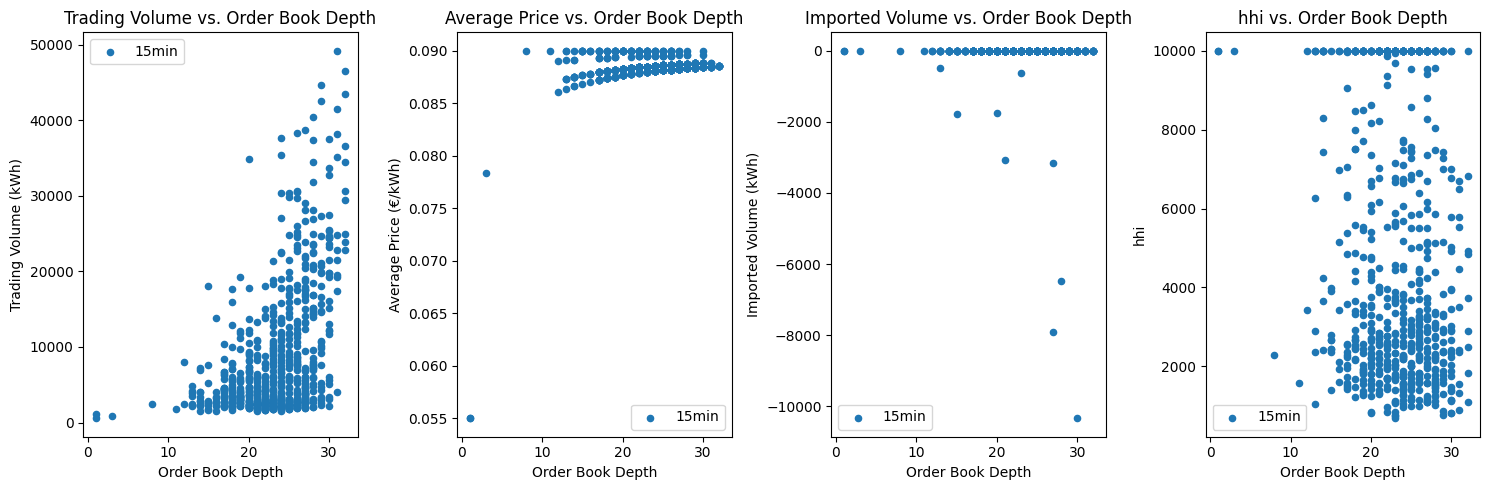

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(15, 5))

for freq in freqs:
    
    performance_data.plot.scatter(x='Order Book Depth', y='Trading Volume (kWh)', ax=axs[0], label=freq)
    performance_data.plot.scatter(x='Order Book Depth', y='Average Price (€/kWh)', ax=axs[1], label=freq)
    performance_data.plot.scatter(x='Order Book Depth', y='Imported Volume (kWh)', ax=axs[2], label=freq)
    performance_data.plot.scatter(x='Order Book Depth', y='hhi', ax=axs[3], label=freq)

axs[0].set_title('Trading Volume vs. Order Book Depth')
axs[1].set_title('Average Price vs. Order Book Depth')
axs[2].set_title('Imported Volume vs. Order Book Depth')
axs[3].set_title('hhi vs. Order Book Depth')

axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()

plt.tight_layout()
plt.show()



In [32]:
# Create a new dataframe with the required format
csv_data_df = pd.DataFrame(columns=['Criteria', 'Score', 'Order Book Depth', 'Frequency'])

# Loop through each row in the performance_data dataframe
for index, row in performance_data.iterrows():
    # Extract the required values and add them to the csv_data_df dataframe
    csv_data_df = pd.concat([
        csv_data_df,
        pd.DataFrame({
            'Criteria': ['Trading Volume (kWh)', 'Average Price (€/kWh)', 'Imported Volume (kWh)'],
            'Score': [row['Trading Volume (kWh)'], row['Average Price (€/kWh)'], row['Imported Volume (kWh)']],
            'Order Book Depth': [row['Order Book Depth'], row['Order Book Depth'], row['Order Book Depth']],
            'Frequency': [freq, freq, freq]
        })
    ], ignore_index=True)

# Save the dataframe to a CSV file
csv_data_df.to_csv('performance_data.csv', index=False)
csv_data_df

                   Criteria        Score  Order Book Depth Frequency
0      Trading Volume (kWh)   562.000000               1.0     15min
1     Average Price (€/kWh)     0.055000               1.0     15min
2     Imported Volume (kWh)     0.000000               1.0     15min
3      Trading Volume (kWh)  1125.000000               1.0     15min
4     Average Price (€/kWh)     0.055000               1.0     15min
...                     ...          ...               ...       ...
2179  Average Price (€/kWh)     0.087500              14.0     15min
2180  Imported Volume (kWh)     0.000000              14.0     15min
2181   Trading Volume (kWh)  2388.000000              14.0     15min
2182  Average Price (€/kWh)     0.086643              14.0     15min
2183  Imported Volume (kWh)     0.000000              14.0     15min

[2184 rows x 4 columns]

In [33]:
results = sorted_data
results['prosumer_cleared_volume'] = 0
results.loc[results['type'] == 'prosumer', 'prosumer_cleared_volume'] = results.loc[results['type'] == 'prosumer', 'cleared_volume'].fillna(0)

results['large_scale_pv_cleared_volume'] = 0
results.loc[results['type'] == 'large_scale_pv', 'large_scale_pv_cleared_volume'] = results.loc[results['type'] == 'large_scale_pv', 'cleared_volume'].fillna(0)

results['fixed_generated_cleared_volume'] = 0
results.loc[results['type'] == 'fixed_generator', 'fixed_generated_cleared_volume'] = results.loc[results['type'] == 'fixed_generator', 'cleared_volume'].fillna(0)
results

                     user  quantity_bid             type  cost_price  Demand  \
time                                                                           
2021-02-23 23:15:00    32         21250  fixed_generator       0.055     562   
2021-02-23 23:30:00    32         20260  fixed_generator       0.055    1125   
2021-02-23 23:45:00    32         20372  fixed_generator       0.055     910   
2021-02-23 23:45:00    23            50         prosumer       0.090     910   
2021-02-23 23:45:00    19           102         prosumer       0.090     910   
...                   ...           ...              ...         ...     ...   
2021-03-03 13:00:00    28          1680         prosumer       0.090    2388   
2021-03-03 13:00:00    12          1105         prosumer       0.090    2388   
2021-03-03 13:00:00    26            48         prosumer       0.090    2388   
2021-03-03 13:00:00    22           140         prosumer       0.090    2388   
2021-03-03 13:00:00     3           120 

In [34]:
snapshot_syst = results.loc[results.index == '2021-02-24 09:15:00']
snapshot_syst.to_csv('snapshot_syst.csv', index=True)

/tmp/ipykernel_20/447077089.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  second_df = results.groupby(results.index).sum()


<AxesSubplot: xlabel='time'>

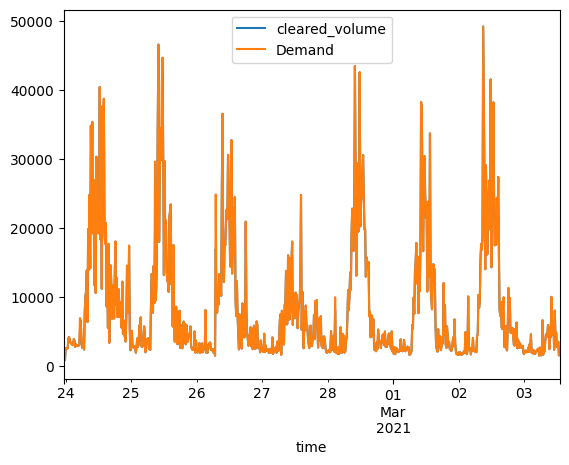

In [35]:
second_df = results.groupby(results.index).sum()
second_df['Demand'] = all_unique_bids.groupby(all_unique_bids.index)['quantity_bid'].sum()
second_df[['cleared_volume','Demand']].plot()

In [36]:
second_df['prosumer_cleared_volume (%)'] = second_df['prosumer_cleared_volume'] / second_df['Demand'] * 100
second_df['prosumer_cost'] = second_df['prosumer_cleared_volume'] * prosumer_cost_price

second_df['large_scale_pv_cleared_volume (%)'] = second_df['large_scale_pv_cleared_volume'] / second_df['Demand'] * 100
second_df['large_scale_pv_cost'] = second_df['large_scale_pv_cleared_volume'] * large_scale_pv_cost_price

second_df['fixed_generated_cleared_volume (%)'] = second_df['fixed_generated_cleared_volume'] / second_df['Demand'] * 100
second_df['fixed_generated_cost'] = second_df['fixed_generated_cleared_volume'] * fixed_generator_cost_price

second_df['total_cost'] = second_df['prosumer_cost'] + second_df['large_scale_pv_cost'] + second_df['fixed_generated_cost']
second_df['final_cost_price'] = second_df['total_cost'] / second_df['Demand']

second_df.fillna(0, inplace=True)

second_df


                     user  quantity_bid  cost_price  Demand  \
time                                                          
2021-02-23 23:15:00    32         21250       0.055     562   
2021-02-23 23:30:00    32         20260       0.055    1125   
2021-02-23 23:45:00    74         20524       0.235     910   
2021-02-24 00:00:00   368          3607       2.070    2613   
2021-02-24 00:15:00   346         18368       1.675    2631   
...                   ...           ...         ...     ...   
2021-03-03 12:00:00   234         23309       1.213    2812   
2021-03-03 12:15:00   195         10202       1.248    3389   
2021-03-03 12:30:00   203         10346       1.158    3583   
2021-03-03 12:45:00   200         23076       1.225    1587   
2021-03-03 13:00:00   237         23072       1.213    2388   

                     cumulative_cleared_volume  cleared_volume  \
time                                                             
2021-02-23 23:15:00                      21250  

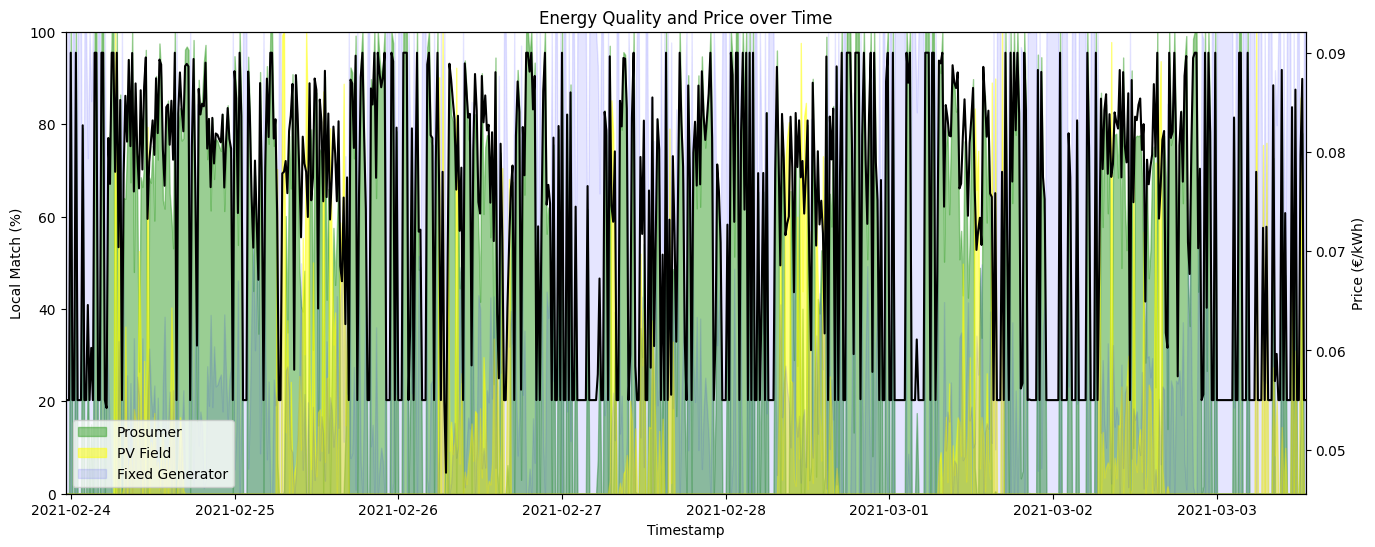

In [37]:
import matplotlib.pyplot as plt

# Group the data by the timestamp column
# create a second y-axis
fig, ax1 = plt.subplots(figsize=(16, 6))
ax2 = ax1.twinx()

# plot the data on each y-axis
ax1.fill_between(second_df.index, second_df["prosumer_cleared_volume (%)"], color="#369f28", alpha=0.5, label="Prosumer")
ax1.fill_between(second_df.index, second_df["large_scale_pv_cleared_volume (%)"], color="yellow", alpha=0.5, label="PV Field")
ax1.fill_between(second_df.index, second_df["fixed_generated_cleared_volume (%)"], color="blue", alpha=0.1, label="Fixed Generator")
ax2.plot(second_df.index, second_df["final_cost_price"], color="black", label='Price €/kWh')

# set the limits and labels for each axis
ax1.set_ylim(0, 100)
ax1.set_xlim(second_df.index.min(), second_df.index.max())
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Local Match (%)')
ax2.set_ylabel('Price (€/kWh)')

# combine legends from both axes
ax1.legend(loc='lower left')
ax2.legend(loc='upper right')

# set a single title and remove duplicate legend
plt.title("Energy Quality and Price over Time")
plt.legend().remove()

# display the plot
plt.show()


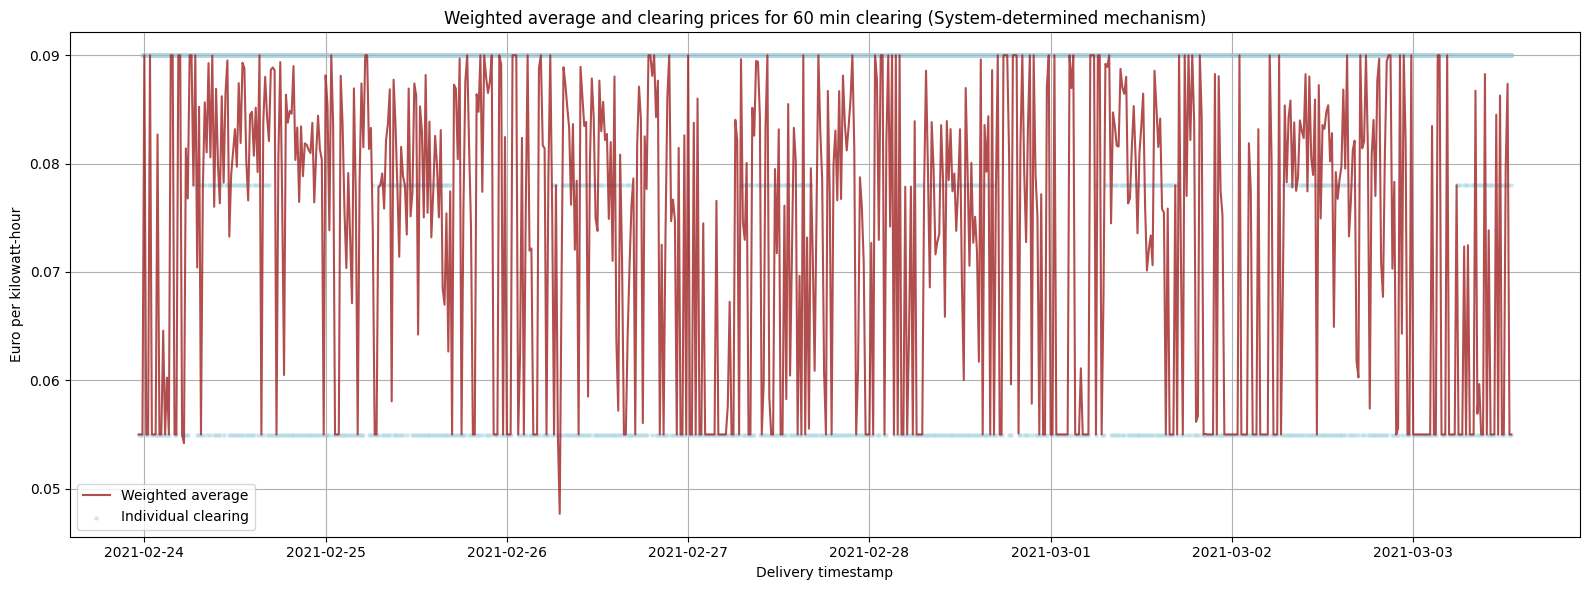

0.01352226520865656
0.0732890211940763


In [38]:
# Increase figure size
plt.figure(figsize=(16, 6))

# Plot weighted average
xvalues = second_df.index
yvalues = second_df['final_cost_price'].tolist()
plt.plot(xvalues, yvalues, color="#a02222", alpha=0.8, label="Weighted average")

# Plot second line
xvalues = results.index
yvalues = results['cost_price'].tolist()
plt.scatter(xvalues, yvalues, color="LightBlue", alpha=0.5, s=5, label="Individual clearing")

# Add labels, title, and legend
plt.xlabel("Delivery timestamp")
plt.ylabel("Euro per kilowatt-hour")
plt.title("Weighted average and clearing prices for 60 min clearing (System-determined mechanism)")
plt.legend()

# Add grid lines
plt.grid(True)

# Display the plot
plt.tight_layout()

# Save the plot as a vector plot in EPS format
plt.savefig("syst_60min.pdf", format="pdf")

# Show the plot
plt.show()

volatility_syst = second_df['final_cost_price'].std()
print(volatility_syst)
wavg_syst = second_df['final_cost_price'].mean()
print(wavg_syst)

In [39]:
second_df

                     user  quantity_bid  cost_price  Demand  \
time                                                          
2021-02-23 23:15:00    32         21250       0.055     562   
2021-02-23 23:30:00    32         20260       0.055    1125   
2021-02-23 23:45:00    74         20524       0.235     910   
2021-02-24 00:00:00   368          3607       2.070    2613   
2021-02-24 00:15:00   346         18368       1.675    2631   
...                   ...           ...         ...     ...   
2021-03-03 12:00:00   234         23309       1.213    2812   
2021-03-03 12:15:00   195         10202       1.248    3389   
2021-03-03 12:30:00   203         10346       1.158    3583   
2021-03-03 12:45:00   200         23076       1.225    1587   
2021-03-03 13:00:00   237         23072       1.213    2388   

                     cumulative_cleared_volume  cleared_volume  \
time                                                             
2021-02-23 23:15:00                      21250  

In [40]:
second_df.sort_index()
start_date = "2021-02-23 23:15:00"
end_date = "2021-02-25 00:00:00"
mask = (second_df.index >= start_date) & (second_df.index < end_date)
second_df = second_df.loc[mask]

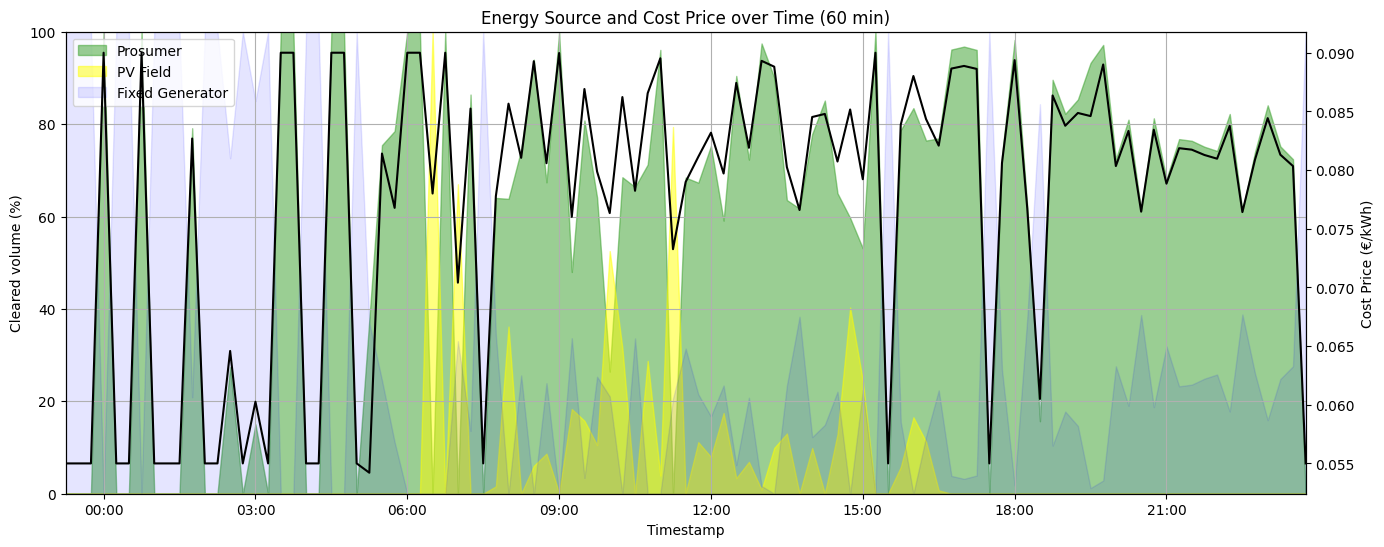

In [41]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Group the data by the timestamp column
# create a second y-axis
fig, ax1 = plt.subplots(figsize=(16, 6))
ax2 = ax1.twinx()

# plot the data on each y-axis
ax1.fill_between(second_df.index, second_df["prosumer_cleared_volume (%)"], color="#369f28", alpha=0.5, label="Prosumer")
ax1.fill_between(second_df.index, second_df["large_scale_pv_cleared_volume (%)"], color="yellow", alpha=0.5, label="PV Field")
ax1.fill_between(second_df.index, second_df["fixed_generated_cleared_volume (%)"], color="blue", alpha=0.1, label="Fixed Generator")
ax2.plot(second_df.index, second_df["final_cost_price"], color="black", label='Price €/kWh')

# set the limits and labels for each axis
ax1.set_ylim(0, 100)
ax1.set_xlim(second_df.index.min(), second_df.index.max())
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Cleared volume (%)')
ax2.set_ylabel('Cost Price (€/kWh)')

# Format the x-axis tick labels as HH:MM format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Add grid lines
ax1.grid(True)

# combine legends from both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# set a single title and remove duplicate legend
plt.title("Energy Source and Cost Price over Time (60 min)")
plt.legend().remove()

# Save the plot as a vector plot in PDF format
plt.savefig("energy_plot_60.pdf", format="pdf")

# Display the plot
plt.show()


# All mechanisms

In [42]:
trading_bandwidth = pd.read_csv('/kaggle/input/trading-bandwidth/retail_prices_4.csv')
trading_bandwidth.set_index('timestamp', inplace=True)
trading_bandwidth.index = pd.to_datetime(trading_bandwidth.index, unit='s')
trading_bandwidth = trading_bandwidth.resample('15min').ffill()
trading_bandwidth.index.name = 'timestamp'
trading_bandwidth.sort_index(inplace=True)

In [43]:
start_date = "2021-02-23 23:15:00"
end_date = "2021-02-25 00:00:00"
mask = (trading_bandwidth.index >= start_date) & (trading_bandwidth.index < end_date)
trading_bandwidth = trading_bandwidth.loc[mask]
mask = (second_df_p2p.index >= start_date) & (second_df_p2p.index < end_date)
second_df_p2p = second_df_p2p.loc[mask]
mask = (second_df_auc.index >= start_date) & (second_df_auc.index < end_date)
second_df_auc = second_df_auc.loc[mask]
mask = (second_df.index >= start_date) & (second_df.index < end_date)
second_df = second_df.loc[mask]

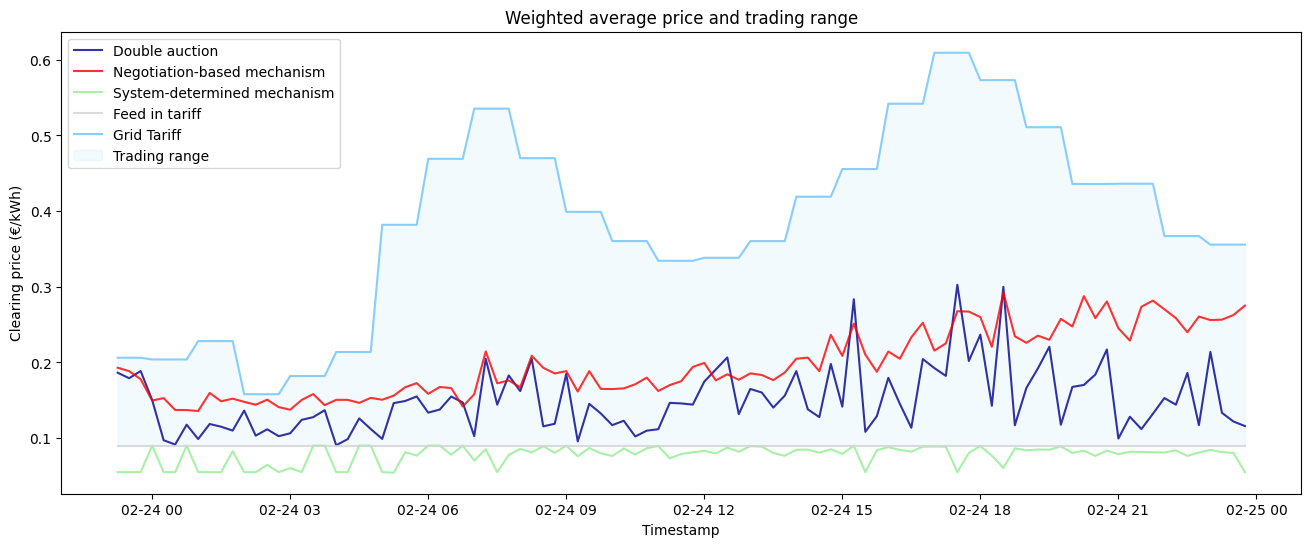

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(16,6))

# Plot weighted average
xvalues1 = second_df_auc.index
yvalues1 = second_df_auc['price_trans']
plt.plot(xvalues1, yvalues1, color="DarkBlue", alpha=0.8, label="Double auction")

xvalues2 = second_df_p2p.index
yvalues2 = second_df_p2p['price_trans']
plt.plot(xvalues2, yvalues2, color="Red", alpha=0.8, label="Negotiation-based mechanism")

xvalues5 = second_df.index
yvalues5 = second_df["final_cost_price"]
plt.plot(xvalues5, yvalues5, color="#90EE90", alpha=0.8, label="System-determined mechanism")

xvalues3 = trading_bandwidth.index
yvalues3 = trading_bandwidth["price_buy"]
plt.plot(xvalues3, yvalues3, color="#D3D3D3", alpha=0.8, label="Feed in tariff")

xvalues4 = trading_bandwidth.index
yvalues4 = trading_bandwidth["price_sell"]
plt.plot(xvalues4, yvalues4, color="#87CEFA", alpha=1.0, label="Grid Tariff")
plt.fill_between(xvalues4, yvalues4, y2=yvalues3, color="#87CEFA", alpha=0.1, label="Trading range")


# Add labels, title and legend
plt.xlabel("Timestamp")
plt.ylabel("Clearing price (€/kWh)")
plt.title("Weighted average price and trading range")
plt.legend()
plt.savefig("Weighted_average_and_trading_interval.pdf", format="pdf")

In [45]:
start_date = "2021-02-23 23:15:00"
end_date = "2021-02-25 00:00:00"
mask = (df_bids_all.index >= start_date) & (df_bids_all.index < end_date)
df_bids_all = df_bids_all.loc[mask]